In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 

In [62]:
df_true = pd.read_csv('True.csv')

In [63]:
df_true.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [64]:
df_true.shape

(21417, 4)

In [65]:
df_fake = pd.read_csv('Fake.csv')

In [66]:
df_fake.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [67]:
df_fake.shape

(23481, 4)

# Data Cleaning

In [68]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [69]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


Since we will be basing our model on text data, out column are not relevant to our model; therefor all other columns will be drop except "text".

In [70]:
df_fake =  df_fake.drop_duplicates() #dropping duplicated values

In [71]:
df_fake = df_fake.dropna() #dropping nan values

In [72]:
df_true = df_true.dropna() #dropping nan values

In [73]:
df_fake.info() #checking to see if nan values are dropped 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23478 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23478 non-null  object
 1   text     23478 non-null  object
 2   subject  23478 non-null  object
 3   date     23478 non-null  object
dtypes: object(4)
memory usage: 917.1+ KB


In [74]:
df_true.info() #checking to see if nan values are dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [75]:
df_fake = df_fake.drop(columns=['title', 'subject', 'date']) #dropping unused variables

In [76]:
df_fake.sample(5) #sampling the dataset

,text
6316,If you ve ever thought our government is compl...
6770,The plans for the Republican convention have s...
12879,Mary J. Blige has a beautiful voice but this s...
1735,"During Watergate, the line became follow the ..."
22940,The Trilateral Commission is international an...


In [77]:
df_true = df_true.drop(columns=['title', 'date','subject'])

In [78]:
df_true.sample()

,text
16926,NEW DELHI (Reuters) - Air pollution in New Del...


We will add a new column that will either be 0 or 1 based on if the news is fake or real. Fake news will be given 0 and real news will be given 1. 

In [79]:
df_fake['Target'] = 0 #adding target column to the dataset

In [80]:
df_fake.sample(5) #sampling the data

,text,Target
2393,"In a shocking move, White House press secretar...",0
11811,https://www.youtube.com/watch?v=mEfQYHciqaQDur...,0
8754,A video uploaded to the Facebook page operated...,0
1127,After the news broke that Trump is going to be...,0
18114,Katie Couric s career has been pretty much in ...,0


In [81]:
df_true['Target'] = 1 #adding target column to the data

In [82]:
df_true.sample(5) #sample of the dataset aftering adding "Target" column

,text,Target
17319,WASHINGTON (Reuters) - The U.S. military said ...,1
15310,BEIJING (Reuters) - Chinese President Xi Jinpi...,1
526,"(Reuters) - U.S. Senator Al Franken, trying to...",1
18128,"BOCHUM, Germany (Reuters) - A 77-year-old spy,...",1
2551,WASHINGTON (Reuters) - U.S. Senate Republican ...,1


Now we will concat both dataset into metadata

In [83]:
data = pd.concat([df_fake, df_true]) #concat the two dataset

In [84]:
data.sample(5) #sample of the dataset

,text,Target
11585,,0
20437,The movie that Hillary will NOT want America t...,0
8451,WASHINGTON (Reuters) - Republican presidential...,1
7722,LAS VEGAS (Reuters) - President Barack Obama o...,1
17441,BEIRUT (Reuters) - The battle for the city of ...,1


# EDA

In [85]:
data

,text,Target
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",1
21414,MINSK (Reuters) - In the shadow of disused Sov...,1
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [86]:
data['Target'].value_counts()

0    23478
1    21417
Name: Target, dtype: int64

([<matplotlib.patches.Wedge at 0x7fddc30f62e0>,
 [Text(-0.07925311595859819, 1.09714125964292, 'Real'),
  Text(0.07925311595859781, -1.09714125964292, 'Fake')],
 [Text(-0.04322897234105355, 0.5984406870779563, '52.30'),
  Text(0.04322897234105334, -0.5984406870779563, '47.70')])

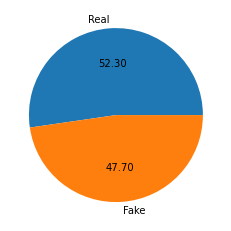

In [87]:
plt.pie(data['Target'].value_counts(), labels=['Real', 'Fake'], autopct="%0.2f")

Observation : The data tells us that is a slight imbalance in the data. There is more data that is real than fake news. 

In [88]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jawadkhattak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [89]:
data['NumberOfCharacters'] = data['text'].apply(len)

In [90]:
data.sample(5)

,text,Target,NumberOfCharacters
13584,We re still waiting to hear if the White Congr...,0,968
8362,Legendary actor Richard Dreyfuss has been hitt...,0,1987
16135,"During Obama s 8 years in office, he took a pa...",0,5331
9395,WASHINGTON (Reuters) - Obama administration of...,1,2471
16656,PARIS (Reuters) - Britain must find concrete p...,1,641


In [112]:
data.describe()

,Target,NumberOfCharacters
count,44895.000000,44895.000000
mean,0.477046,2469.187950
std,0.499478,2171.663707
min,0.000000,1.000000
25%,0.000000,1234.000000
50%,0.000000,2186.000000
75%,1.000000,3105.500000
max,1.000000,51794.000000


In [136]:

for text in data['text']:
    if len(text) <= 1:
        print(text)


In [131]:
(len(data['text'])) <= 1

False

In [101]:
TextTooSmall = 

In [102]:
TextTooSmall

,text,Target,NumberOfCharacters
10923,,0,1
11041,,0,1
11190,,0,1
11225,,0,1
11236,,0,1
...,...,...,...
21826,,0,1
21827,,0,1
21857,,0,1
21873,,0,1
